In [56]:
import sys
sys.path.append(r"C:\Users\siyam\OneDrive\Desktop\Legal DS\project\venv\Lib\site-packages")
import os
from pathlib import Path
import json
import random
import numpy as np
import spacy


from tqdm import tqdm
import spacy
import json
import random
import re
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn import model_selection
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.symbols import ORTH
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt
from spacy.language import Language
from luima_sbd import sbd_utils as luima

## Load Data 

In [2]:
CURATED_ANN_PATH = "../Data/ldsi_w2021-20220221T223611Z-001/ldsi_w2021/ldsi_w21_curated_annotations_v2.json"

In [3]:
with open(CURATED_ANN_PATH, 'r') as j:
     data = json.loads(j.read())

In [4]:
data.keys()

dict_keys(['documents', 'annotations', 'types'])

In [5]:
annotations = data['annotations']
documents_by_id = {d['_id']: d for d in data['documents']}
types_by_id = {t['_id']: t for t in data['types']}
type_ids_by_name = {t['name']: t['_id'] for t in data['types']}
type_names_by_id = {t['_id']: t['name'] for t in data['types']}
doc_id_by_name = {d['name']: d['_id'] for d in data['documents']}
doc_name_by_id = {d['_id']: d['name'] for d in data['documents']}

## Short Data Survey

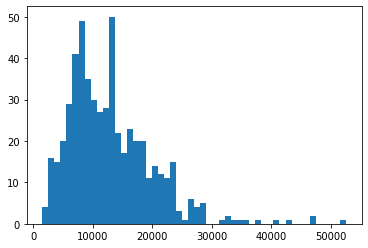

In [6]:
doc_lengths = [len(d['plainText']) for d in documents_by_id.values()]
plt.hist(doc_lengths, bins=50)
plt.show()

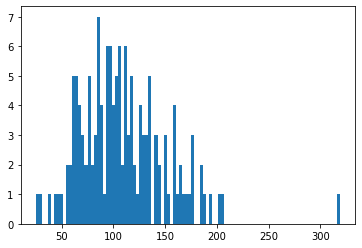

In [7]:
doc_num_annos = [len([a for a in annotations if a['document'] == doc_id])
                 for doc_id in documents_by_id]
doc_num_annos = [n for n in doc_num_annos if n > 0]
plt.hist(doc_num_annos, bins=100)
plt.show()

In [221]:
doc_num_annos

[60,
 96,
 104,
 108,
 105,
 77,
 185,
 62,
 45,
 67,
 98,
 87,
 64,
 94,
 38,
 81,
 99,
 61,
 96,
 114,
 77,
 73,
 62,
 87,
 67,
 112,
 51,
 77,
 107,
 72,
 97,
 102,
 55,
 85,
 59,
 75,
 82,
 71,
 63,
 63,
 25,
 103,
 47,
 30,
 111,
 83,
 84,
 73,
 56,
 65,
 87,
 90,
 69,
 66,
 140,
 154,
 121,
 123,
 149,
 133,
 186,
 169,
 136,
 105,
 144,
 140,
 112,
 128,
 319,
 126,
 97,
 93,
 93,
 78,
 100,
 84,
 84,
 104,
 69,
 84,
 107,
 97,
 119,
 95,
 71,
 89,
 99,
 84,
 105,
 84,
 117,
 64,
 93,
 95,
 158,
 175,
 107,
 64,
 130,
 103,
 135,
 117,
 115,
 76,
 119,
 110,
 99,
 79,
 120,
 160,
 113,
 149,
 135,
 127,
 165,
 111,
 158,
 112,
 145,
 133,
 134,
 116,
 126,
 118,
 194,
 173,
 134,
 151,
 142,
 177,
 205,
 128,
 161,
 177,
 132,
 158,
 165,
 125,
 187,
 170,
 204]

### Common functions

In [8]:
# get all sentences assuming every annotation is a sentence
def make_span_data(documents_by_id, types_by_id, annotations):
    span_data = []
    for a in annotations:
        start = a['start']
        end = a['end']
        document_txt = documents_by_id[a['document']]['plainText']
        atype = a['type']
        sd = {'txt': document_txt[start:end],
              'document': a['document'],
              'type': types_by_id[atype]['name'],
              'start': a['start'],
              'start_normalized': a['start'] / len(document_txt),
              'end': a['end']}
        span_data.append(sd)
    return span_data

In [9]:
def prepare_ann_span_by_doc(spans, doc_id):
    start = []
    end = []
    for span in spans:
        if span['document'] == doc_id:
            start.append(span['start'])
            end.append(span['end'])
    return start, end

In [10]:
def generate_ann_span_by_doc_with_spacy(train_doc_ids, nlp):
    gen_ann_span_by_doc = {}
    for train_id in tqdm(train_doc_ids):
        text = documents_by_id[train_id]['plainText']
        doc = nlp(text)
        sentences = list(doc.sents)
        sentence_starts = [sent.start_char for sent in sentences]
        sentence_ends = [sent.end_char for sent in sentences]
        gen_ann_span_by_doc[train_id] = {'start': sentence_starts, 'end': sentence_ends}
    return gen_ann_span_by_doc

In [11]:
def generate_ann_span_by_doc_with_luima(train_doc_ids):
    gen_ann_span_by_doc = {}
    for train_id in tqdm(train_doc_ids):
        text = documents_by_id[train_id]['plainText']
        doc = luima.text2sentences(text, offsets=False)
        indices = luima.text2sentences(text, offsets=True)
        
        sentence_starts = [ind[0] for ind in indices]
        sentence_ends = [ind[1] for ind in indices]
        gen_ann_span_by_doc[train_id] = {'start': sentence_starts, 'end': sentence_ends}
    return gen_ann_span_by_doc

In [12]:
def find_closest_start_point(train_doc_ids, true_ann_span_by_doc, gen_ann_span_by_doc):
    closest_by_id = {}
    for train_id in train_doc_ids:
        true_starts = []
        closest_neighbors = []
        for true_start in true_ann_span_by_doc[train_id]['start']:
            dist = 7000000
            for gen_start in gen_ann_span_by_doc[train_id]['start']:
                cal_dist = abs(true_start - gen_start)
                if cal_dist < dist:
                    dist = cal_dist
                    closest_neighbor = gen_start
            true_starts.append(true_start)
            closest_neighbors.append(closest_neighbor)
        closest_by_id[train_id] = {'true': true_starts, 'pred': closest_neighbors}
    return closest_by_id

In [13]:
def calculate_error_metrics(train_doc_ids, true_ann_span_by_doc, gen_ann_span_by_doc, closest_by_id):
    TP = 0
    FP = 0
    FN = 0
    
    tot_true_splits = 0
    tot_gen_splits = 0
    for train_id in train_doc_ids:
        true_split_len = len(true_ann_span_by_doc[train_id]['start'])
        gen_split_len = len(gen_ann_span_by_doc[train_id]['start'])
        
        tot_true_splits += true_split_len
        tot_gen_splits += gen_split_len
        
        tp_doc = (abs(np.array(closest_by_id[train_id]['true']) - np.array(closest_by_id[train_id]['pred'])) <= 3).sum()
        fn_doc = true_split_len - tp_doc
        fp_doc = gen_split_len - tp_doc
        
        TP += tp_doc
        FP += fp_doc
        FN += fn_doc
        
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print(f"True split length: {tot_true_splits}")
    print(f"Generated split length: {tot_gen_splits}")
    print(f"TP: {TP}, FP: {FP}, FN: {FN}\n")
    return precision, recall, f1_score

## Create Corpus

In [14]:
spans = make_span_data(documents_by_id, types_by_id, annotations)
span_labels = [s['type'] for s in spans]

In [15]:
train_doc_ids = np.load('../Data/train.npy')

In [16]:
train_doc_ids.shape

(113,)

In [17]:
true_ann_span_by_doc = {}
for train_id in train_doc_ids:
    ann_span_starts, ann_span_ends = prepare_ann_span_by_doc(spans, train_id)
    true_ann_span_by_doc[train_id] = {'start': ann_span_starts, 'end': ann_span_ends}

### Phase 2.1: Using standard sentence segmenter

#### List spans of annotations of each document

In [18]:
%time 
nlp = spacy.load("en_core_web_sm")
gen_ann_span_by_doc = generate_ann_span_by_doc_with_spacy(train_doc_ids, nlp)

CPU times: total: 0 ns
Wall time: 0 ns


100%|████████████████████████████████████████████████████████████████████████████████| 113/113 [00:44<00:00,  2.53it/s]


In [19]:
%time closest_by_id = find_closest_start_point(train_doc_ids, true_ann_span_by_doc, gen_ann_span_by_doc)

CPU times: total: 125 ms
Wall time: 130 ms


In [20]:
precision, recall, f1_score = calculate_error_metrics(train_doc_ids, true_ann_span_by_doc, gen_ann_span_by_doc, closest_by_id)
print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}\nF1_score: {f1_score:.2f}')

True split length: 12450
Generated split length: 12934
TP: 7777, FP: 5157, FN: 4673

Precision: 0.60
Recall: 0.62
F1_score: 0.61


#### Testing the quality of segmentation on a single document

### Phase 2.2: Extending spacy

REPRESENTATION

ATTORNEY FOR THE BOARD

**INTRODUCTION **

FINDING OF FACT

FINDINGS OF FACT

CONCLUSION OF LAW

REASONS AND BASES FOR FINDING AND CONCLUSION

REASONS AND BASES FOR FINDINGS AND CONCLUSION

ORDER

In [95]:
single_word_headers = ["REPRESENTATION",
#                        "WITNESS",
#                        "ATTORNEY",
#                        "REASONS",
                       "____________________________________________",
                       "ORDER",
                       "INTRODUCTION",
#                        "CONCLUSION",
#                        "FINDINGS"
                      ]


other_headers = ["THE ISSUE",
                 "WITNESS AT HEARING ON APPEAL",
                 "ATTORNEY FOR THE BOARD",
                 "FINDINGS OF FACT",
                 "CONCLUSION OF LAW",
                 "REASONS AND BASES FOR FINDING AND CONCLUSION",
                ]

In [88]:
# EXTEND SPACY CELL
@Language.component("set_custom_boundaries_original")
def set_custom_boundaries_original(doc):
    for i, token in enumerate(doc):
        if token.text in ("’s", "'s"):
            doc[i].is_sent_start = False
        elif token.text in ("“", "‘") and i < len(doc) - 1:
            doc[i+1].is_sent_start = False
        elif token.text in ("”", "’"):
            doc[i].is_sent_start = False
        elif token.text in ("\n","\t","\r"," ","  ","   ","    ","DC.","Archive", "NO."):
            doc[i].is_sent_start = False
        elif token.text =="DOCKET":
            doc[i].is_sent_start = False
        elif token.text in ("THE","REPRESENTATION","WITNESS","ATTORNEY","REASONS","____________________________________________","ORDER","INTRODUCTION","CONCLUSION","FINDINGS", "FINDING"):
            doc[i].is_sent_start = True
    return doc

In [209]:
# EXTEND SPACY CELL
@Language.component("set_custom_boundaries")
def set_custom_boundaries(doc):
    for i in range(len(doc)):
        if doc[i].text in ("’s", "'s"):
            doc[i].is_sent_start = False
#         elif doc[i].text in ("“", "‘") and i < len(doc) - 1:
#             doc[i+1].is_sent_start = False
            
#         elif doc[i].text in ("”", "’"):
#             doc[i].is_sent_start = False
            
#         elif doc[i].text in ("\n","\t","\r"," ","  ","   ","    ","DC.","Archive", "NO."):
#             doc[i].is_sent_start = False
        elif doc[i].text in ("\n", "\t", "\r", "DC.","Archive", "NO."):
            doc[i].is_sent_start = False    
            
        elif doc[i].text =="DOCKET" and doc[i+1:i+3].text =="NO.":
            doc[i].is_sent_start = False
            end = i+3
            while i+1<=end:
                doc[i+1].is_sent_start = False
                i += 1
            
        elif doc[i].text in single_word_headers:
#             print(doc[i].text)
            doc[i].is_sent_start = True
            i += 1
            while (doc[i].text.isspace()):
                i += 1
            doc[i].is_sent_start = True
            
        # Fixed    
        elif doc[i].text == "THE" and doc[i+1].text == "ISSUE":
            doc[i].is_sent_start = True
            i += 2
            while (doc[i].text.isspace()):
                i += 1
            doc[i].is_sent_start = True
        # Fixed
        elif doc[i].text == "WITNESS" and doc[i+1: i+5].text == "AT HEARING ON APPEAL":
            doc[i].is_sent_start = True
            end = i + 5
            while i+1<=end:
                doc[i+1].is_sent_start = False
                i += 1
            while (doc[i].text.isspace()):
                i += 1
            doc[i].is_sent_start = True
    
        # Fixed    
        elif doc[i].text == "ATTORNEY" and doc[i+1: i+4].text == "FOR THE BOARD":
            doc[i].is_sent_start = True
            end = i + 4
            while i+1 <= end:
                doc[i+1].is_sent_start = False
                i += 1
            while (doc[i].text.isspace()):
                i += 1
            doc[i].is_sent_start = True            
            
        # Fixed
        elif (doc[i].text == "FINDINGS" or doc[i].text == "FINDING") and doc[i+1: i+3].text == "OF FACT":
            doc[i].is_sent_start = True
            end = i + 3
            while i+1 <= end:
                doc[i+1].is_sent_start = False
                i += 1
            while (doc[i].text.isspace()):
                i += 1
            doc[i].is_sent_start = True      
            
        # Fixed    
        elif doc[i].text == "CONCLUSION" and doc[i+1: i+3].text == "OF LAW":
            doc[i].is_sent_start = True
            end = i + 3
            while i+1 <= end:
                doc[i+1].is_sent_start = False
                i += 1
            while (doc[i].text.isspace()):
                i += 1
            doc[i].is_sent_start = True  
            
        # Fixed    
        elif doc[i].text == "REASONS" and (doc[i+1: i+7].text == "AND BASES FOR FINDING AND CONCLUSION" or doc[i+1: i+7].text == "AND BASES FOR FINDINGS AND CONCLUSION"):
            doc[i].is_sent_start = True
            end = i + 7
            while i+1 <= end:
                doc[i+1].is_sent_start = False
                i += 1
            while (doc[i].text.isspace()):
                i += 1
            doc[i].is_sent_start = True      

        elif doc[i].text.lower() == "on" and doc[i+1:i+4].text == "appeal from the":
            doc[i].is_sent_start = True
            end = i + 4
            while i+1 <= end:
                doc[i+1].is_sent_start = False
                i += 1
            

    return doc

### Test the splits for a single document

In [210]:
doc_id = '61aea55c97ad59b4cfc4129f'

##### View the originally splitted sentences

In [211]:
# Original split
doc_id = doc_id
df = pd.DataFrame([true_ann_span_by_doc[doc_id]['start'], true_ann_span_by_doc[doc_id]['end']]).T
df.columns = ['start', 'end']
df = df.sort_values('start').reset_index(drop=True)
df_true = np.array(df)

test_doc = documents_by_id[doc_id]['plainText']
print(f"Total true splits: {df_true.shape[0]}")
print(f"True splits for the document: {doc_id}")
print("---------------------------------------------------------")
for i, true_span in enumerate(df_true):
    print(f"Sentence {i+1}: {test_doc[true_span[0]: true_span[1]]}\n\n")
    

Total true splits: 185
True splits for the document: 61aea55c97ad59b4cfc4129f
---------------------------------------------------------
Sentence 1: Citation Nr: 0610579	
Decision Date: 04/13/06    Archive Date: 04/26/06

DOCKET NO.  04-19 577	)	DATE
	)
	)


Sentence 2: On appeal from the
Department of Veterans Affairs Regional Office in Manila, the 
Republic of the Philippines


Sentence 3: THE ISSUE


Sentence 4: Entitlement to a higher initial rating for service-connected 
lumbosacral strain with lumbar disc disease, currently 
evaluated as 10 percent disabling.


Sentence 5: REPRESENTATION


Sentence 6: Appellant represented by:	Veterans of Foreign Wars of 
the United States


Sentence 7: WITNESS AT HEARING ON APPEAL


Sentence 8: Veteran


Sentence 9: ATTORNEY FOR THE BOARD


Sentence 10: Tanya A. Smith, Counsel


Sentence 11: INTRODUCTION


Sentence 12: The veteran had active service from December 1998 to April 
2003.


Sentence 13: This matter comes before the Board of Veterans' 

##### View the generated splits using standard segmenter

In [212]:
# Generated splits
doc_id = doc_id
nlp = spacy.load("en_core_web_sm")
gen_ann_span_std = generate_ann_span_by_doc_with_spacy([doc_id], nlp)

df = pd.DataFrame([gen_ann_span_std[doc_id]['start'], gen_ann_span_std[doc_id]['end']]).T
df.columns = ['start', 'end']
df = df.sort_values('start').reset_index(drop=True)
df_gen = np.array(df)

test_doc = documents_by_id[doc_id]['plainText']

print(f"Generated splits with standard segmenter for the document: {doc_id}")
print("-------------------------------------------------------------------------------------")

for i, gen_span in enumerate(df_gen):
    print(f"Sentence {i+1}: {(test_doc[gen_span[0]: gen_span[1]]).strip()}\n\n")


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]

Generated splits with standard segmenter for the document: 61aea55c97ad59b4cfc4129f
-------------------------------------------------------------------------------------
Sentence 1: Citation Nr: 0610579	
Decision Date: 04/13/06    Archive Date: 04/26/06

DOCKET NO.


Sentence 2: 04-19 577	)	DATE
	)
	)

On appeal from the
Department of Veterans Affairs Regional Office in Manila, the 
Republic of the Philippines


THE ISSUE

Entitlement to a higher initial rating for service-connected 
lumbosacral strain with lumbar disc disease, currently 
evaluated as 10 percent disabling.


Sentence 3: REPRESENTATION

Appellant represented by:	Veterans of Foreign Wars of 
the United States


WITNESS AT HEARING ON APPEAL

Veteran



ATTORNEY FOR THE BOARD

Tanya A. Smith, Counsel


INTRODUCTION


Sentence 4: The veteran had active service from December 1998 to April 
2003.


Sentence 5: This matter comes before the Board of Veterans' Appeals 
(Board) on appeal from a July 2003 rating decision of the 
D

##### View the generated splits using the extended segmenter

In [213]:
# Generated splits
doc_id = doc_id
nlp = spacy.load("en_core_web_sm")
# nlp.add_pipe("set_custom_boundaries_original", before="parser")
nlp.add_pipe("set_custom_boundaries", before="parser")
gen_ann_span_ext = generate_ann_span_by_doc_with_spacy([doc_id], nlp)

df = pd.DataFrame([gen_ann_span_ext[doc_id]['start'], gen_ann_span_ext[doc_id]['end']]).T
df.columns = ['start', 'end']
df = df.sort_values('start').reset_index(drop=True)
df_gen = np.array(df)

test_doc = documents_by_id[doc_id]['plainText']

print(f"Generated splits with standard segmenter for the document: {doc_id}")
print("-------------------------------------------------------------------------------------")

for i, gen_span in enumerate(df_gen):
    print(f"Sentence {i+1}: {(test_doc[gen_span[0]: gen_span[1]]).strip()}\n\n")


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]

Generated splits with standard segmenter for the document: 61aea55c97ad59b4cfc4129f
-------------------------------------------------------------------------------------
Sentence 1: Citation Nr: 0610579	
Decision Date: 04/13/06    Archive Date: 04/26/06

DOCKET NO.  04-19 577	)	DATE
	)
	)


Sentence 2: On appeal from the
Department of Veterans Affairs Regional Office in Manila, the 
Republic of the Philippines


Sentence 3: THE ISSUE


Sentence 4: Entitlement to a higher initial rating for service-connected 
lumbosacral strain with lumbar disc disease, currently 
evaluated as 10 percent disabling.


Sentence 5: 


Sentence 6: REPRESENTATION


Sentence 7: Appellant represented by:	Veterans of Foreign Wars of 
the United States


Sentence 8: WITNESS AT HEARING ON APPEAL


Sentence 9: Veteran


Sentence 10: ATTORNEY FOR THE BOARD


Sentence 11: Tanya A. Smith, Counsel


Sentence 12: INTRODUCTION


Sentence 13: The veteran had active service from December 1998 to April 
2003.


Sentence 14

### Error analysis on an individual level

In [214]:
doc_id = '61aea55c97ad59b4cfc4129f'

##### Standard Spacy

In [215]:
# Test for a single document
nlp = spacy.load("en_core_web_sm")
gen_ann_span_standard = generate_ann_span_by_doc_with_spacy([doc_id], nlp)
len(gen_ann_span_standard[doc_id]['start'])
# gen_ann_span_standard

# For the standard spacy
closest_by_id_std = find_closest_start_point(
    [doc_id], 
    true_ann_span_by_doc, 
    gen_ann_span_standard
)

len(closest_by_id[doc_id]['true'])

# For the standard spacy
print(f"Error analysis for the document {doc_id} with standard segmenter")
print("----------------------------------------------------------------------------------")
precision, recall, f1_score = calculate_error_metrics(
    [doc_id], 
    true_ann_span_by_doc, 
    gen_ann_span_standard, 
    closest_by_id_std
)

print(f'\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1_score: {f1_score:.2f}')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]

Error analysis for the document 61aea55c97ad59b4cfc4129f with standard segmenter
----------------------------------------------------------------------------------
True split length: 185
Generated split length: 194
TP: 130, FP: 64, FN: 55


Precision: 0.67
Recall: 0.70
F1_score: 0.69


##### Extended Spacy

In [216]:
# Test for a single document
nlp = spacy.load("en_core_web_sm")
# nlp.add_pipe("set_custom_boundaries_original", before="parser")
nlp.add_pipe("set_custom_boundaries", before="parser")
gen_ann_span_ext = generate_ann_span_by_doc_with_spacy([doc_id], nlp)
len(gen_ann_span_ext[doc_id]['start'])
# gen_ann_span_ext

# For the extended spacy
closest_by_id_ext = find_closest_start_point(
    [doc_id], 
    true_ann_span_by_doc, 
    gen_ann_span_ext
)

len(closest_by_id[doc_id]['true'])

# For the extended spacy
print(f"Error analysis for the document {doc_id} with extended segmenter")
print("----------------------------------------------------------------------------------")
precision, recall, f1_score = calculate_error_metrics(
    [doc_id], 
    true_ann_span_by_doc, 
    gen_ann_span_ext, 
    closest_by_id_ext
)

print(f'\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1_score: {f1_score:.2f}')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]

Error analysis for the document 61aea55c97ad59b4cfc4129f with extended segmenter
----------------------------------------------------------------------------------
True split length: 185
Generated split length: 211
TP: 147, FP: 64, FN: 38


Precision: 0.70
Recall: 0.79
F1_score: 0.74


##### LUIMA SBD

In [217]:
gen_ann_span_luima = generate_ann_span_by_doc_with_luima([doc_id])
len(gen_ann_span_luima[doc_id]['start'])
# gen_ann_span_ext

# For the LUIMA
closest_by_id_luima = find_closest_start_point(
    [doc_id], 
    true_ann_span_by_doc, 
    gen_ann_span_luima
)

len(closest_by_id[doc_id]['true'])

# For the LUIMA

print(f"Error analysis for the document {doc_id} with LUIMA segmenter")
print("----------------------------------------------------------------------------------")

precision, recall, f1_score = calculate_error_metrics(
    [doc_id], 
    true_ann_span_by_doc, 
    gen_ann_span_luima, 
    closest_by_id_luima
)

print(f'\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1_score: {f1_score:.2f}')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]

Error analysis for the document 61aea55c97ad59b4cfc4129f with LUIMA segmenter
----------------------------------------------------------------------------------
True split length: 185
Generated split length: 219
TP: 184, FP: 35, FN: 1


Precision: 0.84
Recall: 0.99
F1_score: 0.91


### Overall error metric analysis

##### Error analysis for the standard segmenter

In [218]:
# Test for a single document
nlp = spacy.load("en_core_web_sm")
print("Splitting the documents")
gen_ann_span_standard = generate_ann_span_by_doc_with_spacy(train_doc_ids, nlp)
print(len(gen_ann_span_standard.keys()))


# Find closest neighbors
closest_by_id_std = find_closest_start_point(
    train_doc_ids, 
    true_ann_span_by_doc, 
    gen_ann_span_standard
)


# Error metrics
precision, recall, f1_score = calculate_error_metrics(
    train_doc_ids, 
    true_ann_span_by_doc, 
    gen_ann_span_standard, 
    closest_by_id_std
)
print("Error metrics using the standard segmenter:")
print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}\nF1_score: {f1_score:.2f}')

Splitting the documents


100%|████████████████████████████████████████████████████████████████████████████████| 113/113 [00:44<00:00,  2.52it/s]

113
True split length: 12450
Generated split length: 12934
TP: 7777, FP: 5157, FN: 4673

Error metrics using the standard segmenter:
Precision: 0.60
Recall: 0.62
F1_score: 0.61


##### Error analysis for the extended segmenter

In [219]:
# Test for a single document
nlp = spacy.load("en_core_web_sm")
# nlp.add_pipe("set_custom_boundaries_original", before="parser")
nlp.add_pipe("set_custom_boundaries", before="parser")

print("Splitting the documents")
gen_ann_span_ext = generate_ann_span_by_doc_with_spacy(train_doc_ids, nlp)
print(len(gen_ann_span_ext.keys()))

# Find closest neighbors
closest_by_id_ext = find_closest_start_point(
    train_doc_ids, 
    true_ann_span_by_doc, 
    gen_ann_span_ext
)

# Error metrics
precision, recall, f1_score = calculate_error_metrics(
    train_doc_ids, 
    true_ann_span_by_doc, 
    gen_ann_span_ext, 
    closest_by_id_ext
)
print("Error metrics using the extended segmenter:")
print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}\nF1_score: {f1_score:.2f}')

Splitting the documents


100%|████████████████████████████████████████████████████████████████████████████████| 113/113 [00:46<00:00,  2.44it/s]

113
True split length: 12450
Generated split length: 14807
TP: 9578, FP: 5229, FN: 2872

Error metrics using the extended segmenter:
Precision: 0.65
Recall: 0.77
F1_score: 0.70


In [220]:
print("Splitting the documents")
gen_ann_span_luima = generate_ann_span_by_doc_with_luima(train_doc_ids)
print(len(gen_ann_span_luima.keys()))

# Find closest neighbors
closest_by_id_luima = find_closest_start_point(
    train_doc_ids, 
    true_ann_span_by_doc, 
    gen_ann_span_luima
)

# Error metrics
precision, recall, f1_score = calculate_error_metrics(
    train_doc_ids, 
    true_ann_span_by_doc, 
    gen_ann_span_luima, 
    closest_by_id_luima
)
print("Error metrics using the LUIMA SBD segmenter:")
print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}\nF1_score: {f1_score:.2f}')

Splitting the documents


100%|████████████████████████████████████████████████████████████████████████████████| 113/113 [01:04<00:00,  1.74it/s]

113
True split length: 12450
Generated split length: 14842
TP: 12320, FP: 2522, FN: 130

Error metrics using the LUIMA SBD segmenter:
Precision: 0.83
Recall: 0.99
F1_score: 0.90


### Other experiments

In [ ]:
upper_texts = []
for i, token in enumerate(doc):
    if token.text.isupper():
        text = {token.text: token.sent}
        upper_texts.append(text)

In [ ]:
# upper_texts

In [ ]:
all_doc_ids_from_ann.count('61aea56f97ad59b4cfc4134b')

In [ ]:
for doc in curated_annotations['documents']:
    if doc['_id'] == '61aea57397ad59b4cfc41399':
        text = doc['plainText']
        break

In [ ]:
from collections import namedtuple
AnnSpan = namedtuple('AnnSpan', 'start end')

In [ ]:
true_ann_span_start = []
true_ann_span_end = []
pos = []
for i, ann in enumerate(curated_annotations['annotations']):
    if ann['document'] == '61aea57397ad59b4cfc41399':
        pos.append(i)
#         true_ann_span.append(AnnSpan(ann['start'], ann['end']))
        true_ann_span_start.append(ann['start'])
        true_ann_span_end.append(ann['end'])

In [ ]:
curated_annotations['annotations'][193]

In [ ]:
import pandas as pd

In [ ]:
df_true = pd.DataFrame([true_ann_span_start, true_ann_span_end]).T
df_true.columns = ['start', 'end']
df_true = df_true.sort_values('start')
df_true = df_true.reset_index(drop=True)

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
# test_doc = curated_annotations['documents'][0]['plainText']
doc = nlp(text)
sentences = list(doc.sents)
pred_ann_span_start = []
pred_ann_span_end = []
for sent in sentences:
#     pred_ann_span.append(AnnSpan(sent.start_char, sent.end_char))
    pred_ann_span_start.append(sent.start_char)
    pred_ann_span_end.append(sent.end_char)

In [ ]:
for idx, row in df.iterrows():
    
    print(row['start'], row['end'])

In [ ]:
pred_ann_span

In [ ]:
df_pred = pd.DataFrame([pred_ann_span_start, pred_ann_span_end]).T
df_pred.columns = ['start', 'end']
df_pred = df_pred.sort_values('start')
df_pred = df_pred.reset_index(drop=True)

In [ ]:
# df_true.iloc([0])

In [ ]:
df_pred = np.array(df_pred, dtype='int')
df_true = np.array(df_true, dtype='int')

In [ ]:
df_pred_start = [pred_span[0] for pred_span in df_pred]
df_true_start = [true_span[0] for true_span in df_true]

In [ ]:
for i, sent in enumerate(sentences):
    print(f"Sentence {i+1}: {sent}\n\n")

#### General observations:
1. Spacy segments a sentence whenever it comes across a fullstop. e.g: 
##### Original sentence: 
Sentence 1: Citation Nr: 0721357	
Decision Date: 07/17/07    Archive Date: 08/02/07

DOCKET NO.  05-13 724	)	DATE
	)
	)
##### Spacy segmented sentence:
Sentence 1: Citation Nr: 0721357	
Decision Date: 07/17/07    Archive Date: 08/02/07

DOCKET NO.

2. Citations are being broken down into sentences too many times

#### Things to improve
1. not only splitting sentence on fullstop, but also for other occurances such as new lines.
2. Different section headers should be considered as a separate sentence.


### Testing the segmentation for a single file and calculating TP, FP, FN
Testing document id: **61aea57397ad59b4cfc41399**

In [ ]:
closest_neighbors = []
cnt = 0

for true_span in df_true:
    tolerance_range = [(true_span[0]-3, true_span[0]+3), ()]
    dist = 10000000
    for pred_span in df_pred:
#         true_span - pred_span
        cal_dist = np.linalg.norm(true_span-pred_span)
        if cal_dist < dist:
            dist = cal_dist
            closest_neighbor = pred_span
            
#             if dist <= 3:
#                 cnt += 1
#         print(true_span, '->', closest_neighbor, dist)
#     closest_neighbors.append(true_span)
#     closest_neighbors.append(closest_neighbor)

#         print(dist)
#         print(f"total matched segments: {cnt}")


In [ ]:
%time test()

In [ ]:
closest_neighbors

In [ ]:
samples = [[0., 0., 0.], [1., 1., 1.], [1., 1., .5]]
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(np.array(df_true), np.array(df_pred))

print(neigh.kneighbors([[1., 1., 1.]]))

In [ ]:
samples = [[0., 0., 0.], [1., 1., 1.], [1., 1., .5]]
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(samples)

print(neigh.kneighbors([[1., 1., 1.]]))

In [ ]:
len(all_doc_ids_from_ann)

In [ ]:
granted_doc_ids = set([doc['_id'] for doc in curated_annotations['documents'] if doc['outcome'] == 'granted'])
denied_doc_ids = set([doc['_id'] for doc in curated_annotations['documents'] if doc['outcome'] == 'denied'])
print(len(granted_doc_ids), len(denied_doc_ids))

In [ ]:
# Filter out the IDs of the 141 documents from a total of 540
ids_annotated_docs = set([ann['document'] for ann in curated_annotations['annotations']])
print(len(ids_annotated_docs))

In [ ]:
granted_ids = sorted(list(granted_doc_ids.intersection(ids_annotated_docs)))
denied_ids = sorted(list(denied_doc_ids.intersection(ids_annotated_docs)))
print(len(granted_ids), len(denied_ids))

In [ ]:
os.environ['PYTHONHASHSEED'] = str(42)
random.seed(42)
np.random.seed(42)


random.shuffle(granted_ids)
random.shuffle(denied_ids)
granted_train, granted_val, granted_test = np.split(granted_ids, [int(len(granted_ids)*0.8), int(len(granted_ids)*0.9)])
denied_train, denied_val, denied_test = np.split(denied_ids, [57, 64])

In [ ]:
train_set, dev_set, test_set = np.concatenate((granted_train, denied_train), axis=0), \
                                np.concatenate((granted_val, denied_val), axis=0), \
                                    np.concatenate((granted_test, denied_test), axis=0), \

print(train_set.shape, dev_set.shape, test_set.shape)

In [ ]:
SAVE_PATH = Path('../Data/')

np.save(SAVE_PATH/'train.npy', train_set)
np.save(SAVE_PATH/'dev.npy', val_set)
np.save(SAVE_PATH/'test.npy', test_set)